In [1]:
#Imports

from import_images import getImages
from import_model import get_cellpose_model
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
#images_directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/uploads"
file_names, images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(images))

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
#directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/datasets/Fluo-C2DL-Huh7/01/models/CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    downsample = cpnet.downsample(x)
    downsample_return = downsample[1].squeeze(0)
    downsample_return = downsample_return.cpu().detach().numpy().tolist()

    for (k, image) in enumerate(downsample_return):
        downsample_return[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    downsample_return = np.array(downsample_return)
    downsample_return = torch.from_numpy(downsample_return)


    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample)
    output = output.squeeze(0)
    output = output[2]
    
    print(output.shape)
    output = output.cpu().detach().numpy().tolist()
    output = cv2.resize(np.array(output), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)
    #output = torch.from_numpy(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)
    #upsample = torch.from_numpy(upsample)

    return downsample_return, upsample, output

In [3]:
cp_downsamples = []
cp_upsamples = []
cp_outputs = []
for image in images:
    downsample, upsample, output = get_pre_activations(image,cpnet)
    cp_downsamples.append(downsample)
    cp_upsamples.append(upsample)
    cp_outputs.append(output)

torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])


In [4]:
class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, upsample, cellprob

In [5]:
def get_crops(image,size):
    assert image.shape[0]%size == 0
    assert image.shape[0] == image.shape[1]
    crops = []
    for i in range(0,image.shape[0],size):
        for j in range(0,image.shape[1],size):
            crops.append(image[i:i+size,j:j+size])
    return crops

def reconstruct_image(crops, size):
    assert len(crops) > 0

    image_size = 1024
    size = 256
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    crop_idx = 0
    for i in range(0, image_size, size):
        for j in range(0, image_size, size):
            image[i:i+size, j:j+size] = crops[crop_idx]
            crop_idx += 1

    return image


In [171]:
import torchvision.transforms as T

train_images, test_images, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_torch, cp_upsamples, cp_outputs, test_size=0.1, random_state=42)

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
images_normalised = []
for image in train_images:
    min_val = torch.min(image)
    max_val = torch.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    images_normalised.append(normalized_image)

images_torch_rotated = []
for image in images_normalised:
    images_torch_rotated.append(image)
    for i in range(3):
        image = torch.rot90(image, 1, [0, 1])
        images_torch_rotated.append(image)
print(1)

images_torch_rotated_flipped = []
for image in images_torch_rotated:
    images_torch_rotated_flipped.append(image)
    images_torch_rotated_flipped.append(torch.flip(image, [1]))
print(2)

cp_upsamples_normalised = []
for upsample in train_upsamples:
    min_val = np.min(upsample)
    max_val = np.max(upsample)
    normalized_upsample = (upsample - min_val) / (max_val - min_val)
    cp_upsamples_normalised.append(normalized_upsample)

cp_upsamples_rotated = []
for upsample in cp_upsamples_normalised:
    cp_upsamples_rotated.append(upsample)
    for i in range(3):
        upsample = np.rot90(upsample, 1, [1, 2])
        cp_upsamples_rotated.append(upsample)
print(5)

cp_upsamples_rotated_flipped = []
for upsample in cp_upsamples_rotated:
    cp_upsamples_rotated_flipped.append(upsample)
    cp_upsamples_rotated_flipped.append(np.flip(upsample, [2]))
print(6)

cp_outputs_normalised = []
for output in train_cellprob:
    min_val = np.min(output)
    max_val = np.max(output)
    normalized_output = (output - min_val) / (max_val - min_val)
    cp_outputs_normalised.append(normalized_output)

cp_outputs_rotated = []
for output in cp_outputs_normalised:
    cp_outputs_rotated.append(output)
    for i in range(3):
        output = np.rot90(output, 1, [0, 1])
        cp_outputs_rotated.append(output)
print(7)

cp_outputs_rotated_flipped = []
for output in cp_outputs_rotated:
    cp_outputs_rotated_flipped.append(output)
    cp_outputs_rotated_flipped.append(np.flip(output, [1]))
print(8)

images_cropped = []
for image in images_torch_rotated_flipped:
    crops = get_crops(image,256)
    for crop in crops:
        images_cropped.append(crop)

cp_upsampled_cropped = []
for (i,upsample) in enumerate(cp_upsamples_rotated_flipped):
    crops_per_chan = []
    for chan in upsample:
        crops = get_crops(chan,256)
        crops_per_chan.append(crops)

    for j in range(16):
        crop_channels_of_crop = []
        for k in range(32):
           crop_channels_of_crop.append(crops_per_chan[k][j])
        crop_channels_of_crop = np.array(crop_channels_of_crop)
        crop_channels_of_crop = crop_channels_of_crop.copy()
        crop_channels_of_crop = torch.from_numpy(crop_channels_of_crop)
        cp_upsampled_cropped.append(crop_channels_of_crop)

cp_outputs_cropped = []
for output in cp_outputs_rotated_flipped:
    crops = get_crops(output,256)
    for crop in crops:
        crop = torch.from_numpy(crop.copy())
        cp_outputs_cropped.append(crop)

1
2
5
6
7
8


In [174]:
train_dataset = ImageDataset(images_cropped[:10], cp_upsampled_cropped[:10], cp_outputs_cropped[:10])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = ImageDataset(test_images, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [172]:
print(torch.unique(cp_outputs_cropped[0]))

tensor([0.1379, 0.1396, 0.1398,  ..., 0.3480, 0.3636, 0.3746],
       dtype=torch.float64)


In [175]:
print(images_cropped[2])

tensor([[0.0158, 0.0158, 0.0277,  ..., 0.0158, 0.0435, 0.0158],
        [0.0198, 0.0079, 0.0198,  ..., 0.0237, 0.0237, 0.0198],
        [0.0277, 0.0158, 0.0198,  ..., 0.0237, 0.0316, 0.0316],
        ...,
        [0.0119, 0.0198, 0.0119,  ..., 0.0079, 0.0079, 0.0158],
        [0.0079, 0.0158, 0.0119,  ..., 0.0198, 0.0158, 0.0079],
        [0.0079, 0.0079, 0.0119,  ..., 0.0158, 0.0158, 0.0119]])


In [176]:
class LF_three(torch.nn.Module):
    def __init__(self):
        super(LF_three, self).__init__()
    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())

        y_3_pred = F.sigmoid(y_3_pred)
        y_3_true = F.sigmoid(y_3_true)
        y_3_loss = F.binary_cross_entropy(y_3_pred, y_3_true.float())

        y_3_pred = y_3_pred > 0.5
        y_3_true = y_3_true > 0.5
        y_3_pred = y_3_pred.float()
        y_3_true = y_3_true.float()
        y_3_loss_bin = F.mse_loss(y_3_pred, y_3_true.float())

        #print(y_32_loss, y_3_loss)

        return y_32_loss * 0.8 + y_3_loss * 0.2 + y_3_loss_bin * 0.2

In [177]:
def trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler, epoch_num, step, device):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, upsample, cp_output in train_loader:
        #cast to float32
        image = image.float()
        upsample = upsample.float()
        cp_output = cp_output.float()
        (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)
        
        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, y_3_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)
        
        #pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)
        
        if step == 1:
            #transform = T.Resize(512)
            #y_32_pred = transform(y_32_pred)
            loss = loss_fn(y_32_pred,  upsample) # calculate the loss of that prediction
            #loss = loss_fn(y_32_pred, upsample, cp_output)
        elif step == 2:
            if 4 == 5:
                kl_loss = torch.nn.KLDivLoss(reduction="mean")
                transform = T.Resize(1024)
                cp_output_t = transform(cp_output)

                y_3_pred = F.sigmoid(y_3_pred)
                #cp_output_t = F.sigmoid(cp_output_t)

                loss = kl_loss(y_3_pred.double().log(), cp_output_t.double().log())
            #transform = T.Resize(512)
            #y_3_pred = transform(y_3_pred)
            #print(y_3_pred.shape, cp_output.shape)
            loss = loss_fn(y_3_pred, cp_output)
            #transform = T.Resize(1024)
            #cp_output_t = transform(cp_output)
            #cp_output_t_bin = torch.where(cp_output_t > 0.5,
                                      #torch.ones_like(cp_output_t),
                                      #torch.zeros_like(cp_output_t))
            #loss = loss_fn(y_3_pred, cp_output_t)
            #transform = T.Resize(512)
            #y_3_pred = transform(y_3_pred)
            #loss = loss_fn(y_3_pred,  cp_output)
        elif step == 3:
            loss = loss_fn(y_32_pred,  upsample, y_3_pred, cp_output) # calculate the loss of that prediction
            

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if step == 2 or step == 3:
        iou_score = 0
        for image, upsample, cp_output in test_loader:
            image = image.float()
            upsample = upsample.float()
            cp_output = cp_output.float()
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device))

            image = image.unsqueeze(1)

            image_crops = get_crops(image.squeeze(),256)
            y_3_pred = []
            for crop in image_crops:
                crop = crop.unsqueeze(0)
                crop = crop.unsqueeze(0)
                y_16_pred, y_32_pred, pred = unet(crop)
                pred = pred.squeeze()
                y_3_pred.append(pred.cpu().detach().numpy().tolist())

            y_3_pred = reconstruct_image(y_3_pred,256)

            #y_16_pred, y_32_pred, y_3_pred = unet(image)
            
            #y_32_pred = y_32_pred.squeeze(1)
            #y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = 1/(1+np.exp(-y_3_pred))
            #y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            #transform = T.Resize(1024)
            #cp_output = transform(cp_output)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)

            intersection = np.logical_and(cp_output, y_3_pred)
            union = np.logical_or(cp_output, y_3_pred)
            iou_score += np.sum(intersection) / np.sum(union)

        for image, upsample, cp_output in test_loader:
            
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device))

            image = image.unsqueeze(1)
            y_16_pred, y_32_pred, y_3_pred = unet(image)
            y_32_pred = y_32_pred.squeeze(1)
            y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = F.sigmoid(y_3_pred)
            y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)
            
            if epoch_num % 10 == 0:
                plt.subplot(1,4,1)
                plt.imshow(y_3_pred)
                plt.subplot(1,4,2)
                plt.imshow(y_3_pred)
                plt.subplot(1,4,3)
                plt.imshow(cp_output)
                plt.subplot(1,4,4)
                plt.imshow(cp_output)
                plt.show()
            
            break


        iou_score = iou_score/len(test_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        if step == 1:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)
        elif step == 2:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)
        elif step == 3:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)

    return unet

In [178]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('cuda:0')

C:\Users\rz200\AppData\Local\Temp\ipykernel_8276\2080858795.py:87: RuntimeWarning: overflow encountered in exp
  y_3_pred = 1/(1+np.exp(-y_3_pred))


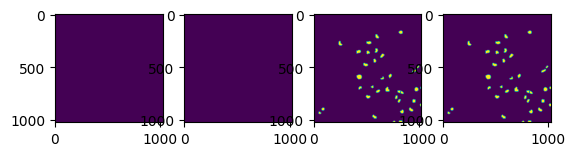

Epoch  0 Training loss:  0.13805596828460692 IoU score:  0.0 Time:  1.134084701538086
Epoch  1 Training loss:  0.13805594444274902 IoU score:  0.0 Time:  0.8489961624145508
Epoch  2 Training loss:  0.1380558729171753 IoU score:  0.0 Time:  0.8615431785583496
Epoch  3 Training loss:  0.13805577754974366 IoU score:  0.0 Time:  0.8532097339630127
Epoch  4 Training loss:  0.13805575370788575 IoU score:  0.0 Time:  0.8451595306396484
Epoch  5 Training loss:  0.138055682182312 IoU score:  0.0 Time:  0.8510286808013916
Epoch  6 Training loss:  0.13805564641952514 IoU score:  0.0 Time:  0.8431622982025146
Epoch  7 Training loss:  0.1380556344985962 IoU score:  0.0 Time:  0.8465943336486816
Epoch  8 Training loss:  0.13805558681488037 IoU score:  0.0 Time:  0.8377416133880615
Epoch  9 Training loss:  0.13805550336837769 IoU score:  0.0 Time:  0.8340072631835938


KeyboardInterrupt: 

In [180]:
#TODO: add test loss here
third_loss_fn = LF_three()
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.000001, max_lr=0.1)

for epoch in range(700):
    unet = trainEpoch(unet, train_loader, test_loader, third_loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch,device='cuda:0',step=3)

(array([  2.67911458,   2.86955309,   3.0310812 , ..., 988.40759277,
       988.44561768, 988.46551514]), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))


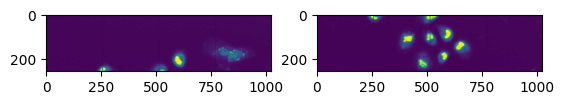

(array([0.75227201, 0.79479754, 0.80312696, ..., 1.        , 1.        ,
       1.        ]), array([     1,      1,      1, ...,   1263,   2612, 137954], dtype=int64))
(array([1]), array([1048576], dtype=int64))


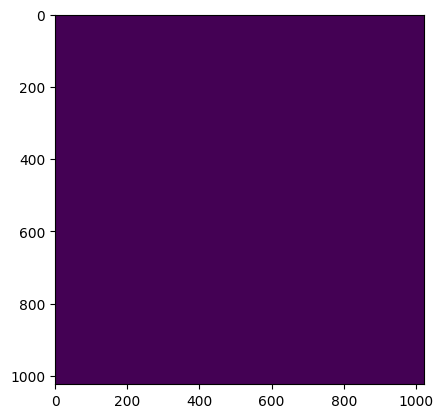

(array([1]), array([1048576], dtype=int64))
1024


In [163]:
test_image = test_images[0]
test_image = test_image.to('cuda:0')
test_image = test_image.unsqueeze(1)

image_crops = get_crops(test_image.squeeze(),256)
y_3_pred = []
for crop in image_crops:
    crop = crop.unsqueeze(0)
    crop = crop.unsqueeze(0)
    y_16_pred, y_32_pred, pred = unet(crop)
    pred = pred.squeeze()
    y_3_pred.append(pred.cpu().detach().numpy().tolist())

y_3_pred_row_1 = []
for i in range(0,4):
    y_3_pred_row_1.append(y_3_pred[i])
y_3_pred_row_1 = np.concatenate(y_3_pred_row_1,axis=1)

y_3_pred_row_2 = []
for i in range(4,8):
    y_3_pred_row_2.append(y_3_pred[i])
y_3_pred_row_2 = np.concatenate(y_3_pred_row_2,axis=1)

y_3_pred_row_3 = []
for i in range(8,12):
    y_3_pred_row_3.append(y_3_pred[i])
y_3_pred_row_3 = np.concatenate(y_3_pred_row_3,axis=1)

y_3_pred_row_4 = []
for i in range(12,16):
    y_3_pred_row_4.append(y_3_pred[i])
y_3_pred_row_4 = np.concatenate(y_3_pred_row_4,axis=1)


print(np.unique(y_3_pred_row_1, return_counts=True))

plt.subplot(1,2,1)
plt.imshow(y_3_pred_row_1)
plt.subplot(1,2,2)
plt.imshow(y_3_pred_row_2)
plt.show()

#concatenate y_3_pred_row_1 with y_3_pred_row_2
y_3_pred = []
y_3_pred.append(y_3_pred_row_1)
y_3_pred.append(y_3_pred_row_2)
y_3_pred.append(y_3_pred_row_3)
y_3_pred.append(y_3_pred_row_4)
y_3_pred = np.concatenate(y_3_pred,axis=0)
y_3_pred = 1/(1+np.exp(-y_3_pred))
print(np.unique(y_3_pred,return_counts=True))

#replace values in y_3_pred with 0 or 1 if they are above or below 0.5
y_3_pred = np.where(y_3_pred > 0.5, 1, 0)
print(np.unique(y_3_pred,return_counts=True))

plt.imshow(y_3_pred)
plt.show()

print(np.unique(y_3_pred,return_counts=True))
print(len(y_3_pred))

if 4 == 5:
    print(np.unique(y_3_pred[0]))
    pred = reconstruct_image(y_3_pred,256)
    print(np.unique(pred))
    pred = 1/(1+np.exp(-pred))
    pred = pred[0:200,0:200]
    print(np.unique(pred,return_counts=True))
    print(pred)
    plt.imshow(pred > 0.1)